# Host mutation troubleshooting

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import optuna

from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
)

from optuna.samplers import TPESampler

import pandas as pd
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots


import matplotlib.pyplot as plt

import seaborn as sns

from polymodel.fitting import (
    HostMaxMutationObjective,
    FungMaxMutationObjective,
    score_for_this_df_weighted,
    fitting_df,
)
    
from polymodel.config import Config

from polymodel.consts import (
    MUTATION_PROP,
    DEFAULT_P,
    HOST_MUTATION_SCALE,
    FUNG_MUTATION_SCALE,
)

from plots.fns import standard_layout, get_text_annotation

In [3]:
sns.set_palette('viridis')

In [123]:
host_fit_config = Config(
    'single',
    cultivar='Mariboss',
    n_k=40,
    n_l=500,
    mutation_proportion=MUTATION_PROP,
    mutation_scale_fung=1,
    mutation_scale_host=1,
)

CONFIG
------
I0_single = 0.0098570319660089
beta_single = 0.0078954305108593
cultivar = Mariboss
host_growth = True
host_on = None
k_b = None
k_mu = None
l_b = None
l_mu = None
mutation_on = True
mutation_proportion = 5.6521739130434784e-05
mutation_scale_fung = 1
mutation_scale_host = 1
n_iterations = None
n_k = 40
n_l = 500
n_years = 25
replace_cultivars = None
sprays = None
type = single



In [61]:
obj_h = HostMaxMutationObjective(host_fit_config)

In [62]:
control_data_h = obj_h.df.loc[:, ['data_control', 'year']]

control_data_h.head()

,data_control,year
0,58.530550,2007
1,33.624795,2016


In [82]:
yh = obj_h.run_model(params = {'mean': 0.865, 'mutation_scale': 0.006})

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


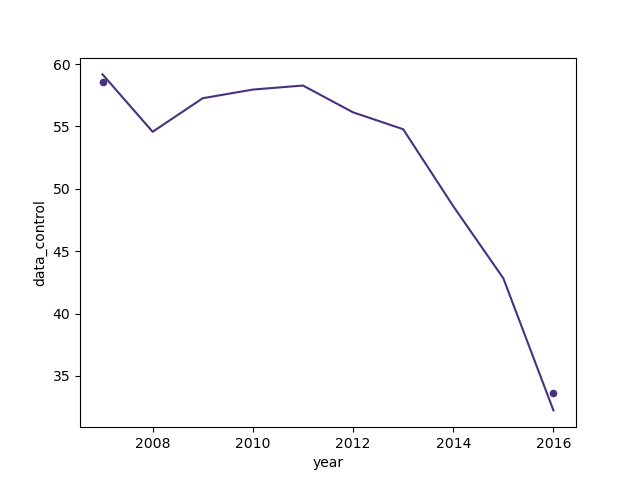

In [83]:
f, ax = plt.subplots()

control_data_h.plot.scatter(x='year', y='data_control', ax=ax)

ax.plot(np.arange(2007, 2017), yh)

# Test out

Why is the host fit so bad, and would it ever work for the appropriate choice of mutation scale?

In [63]:
from copy import deepcopy

In [64]:
from polymodel.utils import initial_point_distribution, find_beta_vectorised
from polymodel.simulator import Simulator

In [65]:
from polymodel.utils import get_dist_mean

In [125]:
config_use = deepcopy(host_fit_config)

In [67]:
input_severities = (
    pd.read_csv(
        '../data/03_model_inputs/input_severities_host.csv'
    )
    .iloc[:, 1:]
    .loc[lambda df: df.cultivar == config_use.cultivar]
)

In [68]:
input_severities_use = 0.01*np.array(input_severities.worst_stb)

In [69]:
I0s = [config_use.I0_single] * len(input_severities_use)

In [35]:
betas = find_beta_vectorised(
    0.01*input_severities.worst_stb,
    config_use.I0_single
)

In [126]:
def get_output(ms_in, mu_in):

    config_use.mutation_scale_host = ms_in

    NOT_USED_NUM = 0.5

    sim_on = Simulator(
        host_plant_on=True,
        fungicide_on=False,
        l_mu=NOT_USED_NUM,
        l_b=NOT_USED_NUM,
        k_mu=NOT_USED_NUM,
        k_b=NOT_USED_NUM,
        config=config_use
    )
    
    point_dist = initial_point_distribution(
        config_use.n_l,
        mu_in
    )

    sim_on.initial_l_dist = point_dist

    output_trait_on = (
        sim_on
        .run_model(
            I0_vec=I0s,
            beta_vec=3*betas
        )
    )

    return output_trait_on

Something weird happening with mutation scales. 

When mu is big, the final host mean is non monotonic with respect to mutation scale, which is weird.

When mu is 0.5 it behaves as expected.

So something strange happens with the way mutation works, possibly a mistake in the dispersal kernel or possibly something else odd.

**Update**: seems to be that when density near 1, mutation pushes you away from that. Also selection is quite small because 0.86 and 1 are quite close, so relative growth rates are quite similar.

### Dist plot

In [127]:
mu = 0.86

Text(0, 0.5, 'Host trait density (log scale)')

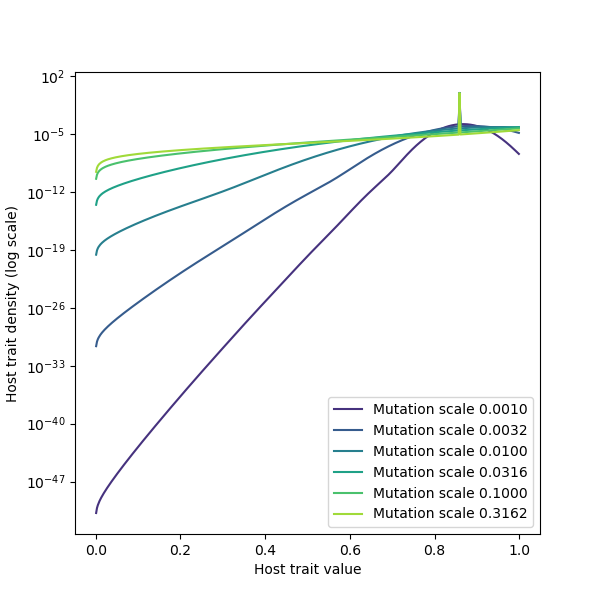

In [72]:
ind_check = 2

f, ax = plt.subplots(figsize=(6,6))

for ms in np.logspace(-3,-0.5, 6):
    ot1 = get_output(ms, mu)
    
    ax.plot(ot1['l_vec'], ot1['host_dists'][:, ind_check], label=f'Mutation scale {ms:.4f}')

ax.legend()

ax.set_yscale('log')

ax.set_xlabel('Host trait value')
ax.set_ylabel('Host trait density (log scale)')

In [39]:
# f.savefig(f'../figures/paper_figs/rough/mutation_scales_final_dist_{mu}.jpg')

### Scatter

Text(0, 0.5, 'Host mean, year 10')

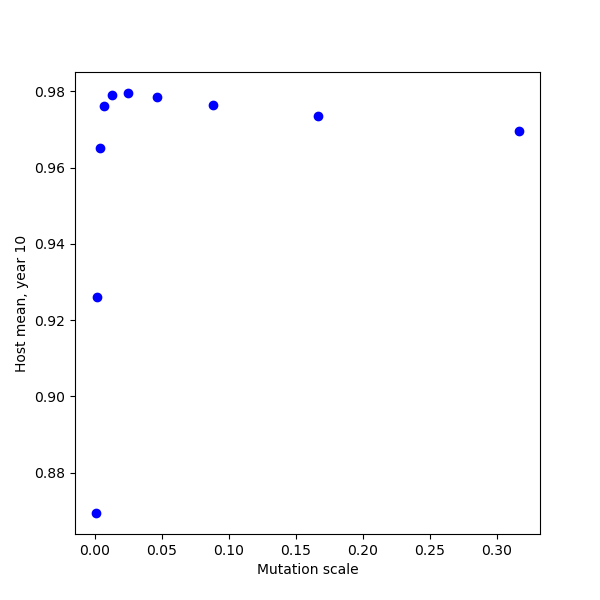

In [128]:
f, ax = plt.subplots(figsize=(6,6))

for ms in np.logspace(-3,-0.5, 10):
    ot1 = get_output(ms, mu)
    dm1 = get_dist_mean(ot1['host_dists'], ot1['l_vec'])

    ax.scatter(ms, dm1[-1], label=f'Mutation scale = {ms:.4f}', c='b')

ax.set_xlabel('Mutation scale')
ax.set_ylabel('Host mean, year 10')

In [129]:
f.savefig(f'../figures/paper_figs/rough/mutation_scale_scatter_{mu}_high_beta.jpg')

### Full

In [42]:
cmap = sns.color_palette("viridis", as_cmap=True)

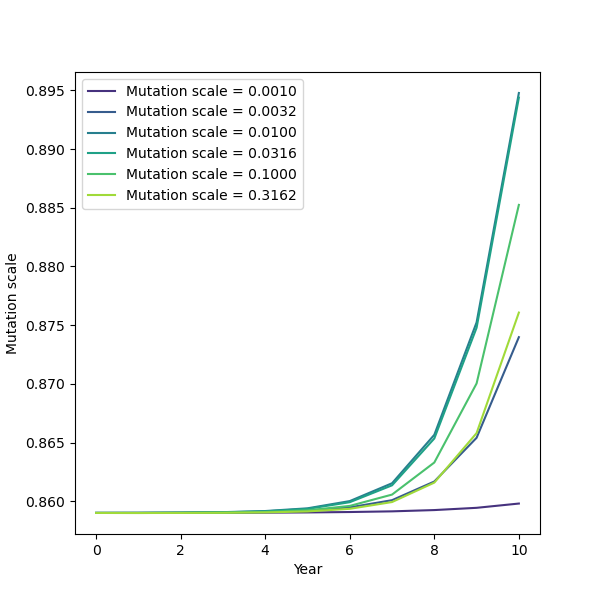

In [43]:
f, ax = plt.subplots(figsize=(6,6))

for ms in np.logspace(-3,-0.5, 6):
    ot1 = get_output(ms, mu)
    dm1 = get_dist_mean(ot1['host_dists'], ot1['l_vec'])

    ax.plot(dm1, label=f'Mutation scale = {ms:.4f}')

ax.set_xlabel('Year')
ax.set_ylabel('Mutation scale')

ax.legend()

In [44]:
f.savefig(f'../figures/paper_figs/rough/mutation_scales_full_{mu}.jpg')

## Testing dispersal

In [45]:
from polymodel.utils import edge_values

In [90]:
from scipy.stats import norm, expon

In [91]:
expon.cdf(1, loc=0, scale=10)

0.09516258196404044

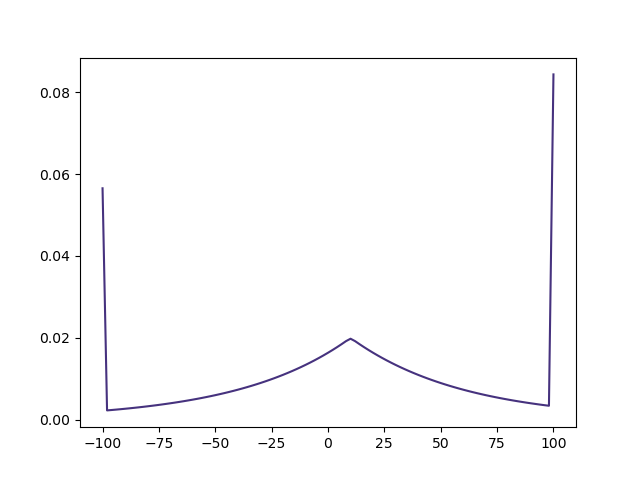

In [122]:
f, ax = plt.subplots()

LOC = 10

SCALE = 50

x = np.linspace(-100, 100, 101)

x2 = np.linspace(-101, 101, 102)

y = np.zeros(len(x2))

for ind, xx in enumerate(x2):
    y[ind] = 0.5* (
        expon.cdf(xx, loc=LOC, scale=SCALE)
        + 1 - expon.cdf(-xx, loc=-LOC, scale=SCALE)
    )
    
# ax.plot(x, y)

dispersing = np.diff(y)

top = 1 - y[-1]

bottom = y[0]

dispersing[0] += bottom

dispersing[-1] += top

ax.plot(x, dispersing)

In [116]:
x

array([-100.,  -98.,  -96.,  -94.,  -92.,  -90.,  -88.,  -86.,  -84.,
        -82.,  -80.,  -78.,  -76.,  -74.,  -72.,  -70.,  -68.,  -66.,
        -64.,  -62.,  -60.,  -58.,  -56.,  -54.,  -52.,  -50.,  -48.,
        -46.,  -44.,  -42.,  -40.,  -38.,  -36.,  -34.,  -32.,  -30.,
        -28.,  -26.,  -24.,  -22.,  -20.,  -18.,  -16.,  -14.,  -12.,
        -10.,   -8.,   -6.,   -4.,   -2.,    0.,    2.,    4.,    6.,
          8.,   10.,   12.,   14.,   16.,   18.,   20.,   22.,   24.,
         26.,   28.,   30.,   32.,   34.,   36.,   38.,   40.,   42.,
         44.,   46.,   48.,   50.,   52.,   54.,   56.,   58.,   60.,
         62.,   64.,   66.,   68.,   70.,   72.,   74.,   76.,   78.,
         80.,   82.,   84.,   86.,   88.,   90.,   92.,   94.,   96.,
         98.,  100.])

In [117]:
x2

array([-101.,  -99.,  -97.,  -95.,  -93.,  -91.,  -89.,  -87.,  -85.,
        -83.,  -81.,  -79.,  -77.,  -75.,  -73.,  -71.,  -69.,  -67.,
        -65.,  -63.,  -61.,  -59.,  -57.,  -55.,  -53.,  -51.,  -49.,
        -47.,  -45.,  -43.,  -41.,  -39.,  -37.,  -35.,  -33.,  -31.,
        -29.,  -27.,  -25.,  -23.,  -21.,  -19.,  -17.,  -15.,  -13.,
        -11.,   -9.,   -7.,   -5.,   -3.,   -1.,    1.,    3.,    5.,
          7.,    9.,   11.,   13.,   15.,   17.,   19.,   21.,   23.,
         25.,   27.,   29.,   31.,   33.,   35.,   37.,   39.,   41.,
         43.,   45.,   47.,   49.,   51.,   53.,   55.,   57.,   59.,
         61.,   63.,   65.,   67.,   69.,   71.,   73.,   75.,   77.,
         79.,   81.,   83.,   85.,   87.,   89.,   91.,   93.,   95.,
         97.,   99.,  101.])

In [47]:
def dispersal(vec, parent_index, mut_scale):

    stan_dev = mut_scale**0.5

    edges = edge_values(len(vec))

    disp = norm.cdf(edges, loc=vec[parent_index], scale=stan_dev)
    
    # return disp

    dispersing = np.diff(disp)

    top = 1 - disp[-1]

    bottom = disp[0]

    dispersing[0] += bottom

    dispersing[-1] += top
    
    return dispersing

In [48]:
disp = dispersal(ot1['l_vec'], 499, 0.1)

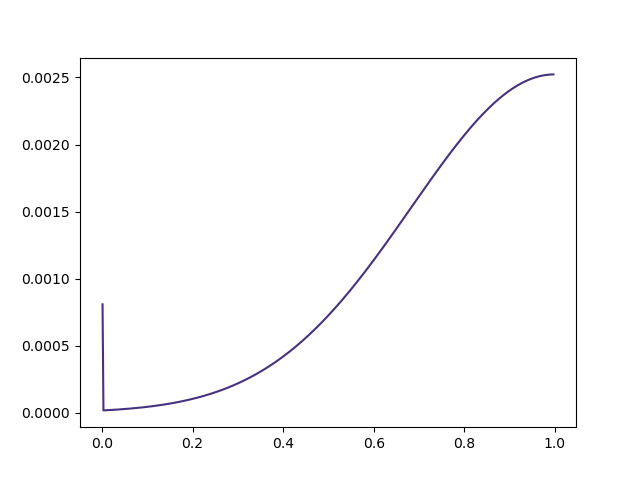

In [49]:
f, ax = plt.subplots()

ax.plot(ot1['l_vec'][:-1], disp[:-1])

In [50]:
kern = get_kernel(
    ot1['l_vec'],
    host_fit_config.mutation_proportion,
    0.01
)

kern

array([[9.99971965e-01, 4.50880532e-07, 4.50610094e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.80353842e-05, 9.99943929e-01, 4.50880532e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.75845037e-05, 4.50880532e-07, 9.99943929e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.71156970e-28, 1.93277871e-28, 2.35644025e-28, ...,
        9.99943929e-01, 4.50880532e-07, 2.75845037e-05],
       [7.12691690e-28, 1.58465280e-28, 1.93277871e-28, ...,
        4.50880532e-07, 9.99943929e-01, 2.80353842e-05],
       [5.82820626e-28, 1.29871064e-28, 1.58465280e-28, ...,
        4.50610094e-07, 4.50880532e-07, 9.99971965e-01]])

In [56]:
kern2 = kern - (1-host_fit_config.mutation_proportion) * np.identity(500)
kern2

array([[2.84863549e-05, 4.50880532e-07, 4.50610094e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.80353842e-05, 4.50970714e-07, 4.50880532e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.75845037e-05, 4.50880532e-07, 4.50970714e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.71156970e-28, 1.93277871e-28, 2.35644025e-28, ...,
        4.50970714e-07, 4.50880532e-07, 2.75845037e-05],
       [7.12691690e-28, 1.58465280e-28, 1.93277871e-28, ...,
        4.50880532e-07, 4.50970714e-07, 2.80353842e-05],
       [5.82820626e-28, 1.29871064e-28, 1.58465280e-28, ...,
        4.50610094e-07, 4.50880532e-07, 2.84863549e-05]])

In [59]:
pd.DataFrame(kern2).describe()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
count,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,...,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02
mean,2.311826e-06,5.787447e-08,5.877569e-08,5.967601e-08,6.057507e-08,6.147251e-08,6.236798e-08,6.326113e-08,6.415160e-08,6.503905e-08,...,6.503905e-08,6.415160e-08,6.326113e-08,6.236798e-08,6.147251e-08,6.057507e-08,5.967601e-08,5.877569e-08,5.787447e-08,2.311826e-06
std,5.802842e-06,1.237540e-07,1.249665e-07,1.261581e-07,1.273283e-07,1.284767e-07,1.296027e-07,1.307061e-07,1.317865e-07,1.328434e-07,...,1.328434e-07,1.317865e-07,1.307061e-07,1.296027e-07,1.284767e-07,1.273283e-07,1.261581e-07,1.249665e-07,1.237540e-07,5.802842e-06
min,5.828206e-28,1.298711e-28,1.584653e-28,1.932779e-28,2.356440e-28,2.871819e-28,3.498516e-28,4.260269e-28,5.185809e-28,6.309897e-28,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.186389e-18,3.586123e-19,4.162667e-19,4.829971e-19,5.602006e-19,6.494847e-19,7.526977e-19,8.719640e-19,1.009724e-18,1.168782e-18,...,1.168751e-18,1.007165e-18,8.738179e-19,7.561584e-19,6.479117e-19,5.584905e-19,4.847572e-19,4.172990e-19,3.576849e-19,2.185329e-18
50%,1.799259e-11,1.954831e-12,2.158666e-12,2.382803e-12,2.629160e-12,2.899827e-12,3.197081e-12,3.523396e-12,3.881464e-12,4.274211e-12,...,4.274211e-12,3.881464e-12,3.523396e-12,3.197081e-12,2.899827e-12,2.629160e-12,2.382803e-12,2.158666e-12,1.954831e-12,1.799259e-11
75%,3.662201e-07,2.109182e-08,2.215758e-08,2.326789e-08,2.442407e-08,2.562745e-08,2.687936e-08,2.818116e-08,2.953419e-08,3.093980e-08,...,3.093980e-08,2.953419e-08,2.818116e-08,2.687936e-08,2.562745e-08,2.442407e-08,2.326789e-08,2.215758e-08,2.109182e-08,3.662201e-07
max,2.848635e-05,4.509707e-07,4.509707e-07,4.509707e-07,4.509707e-07,4.509707e-07,4.509707e-07,4.509707e-07,4.509707e-07,4.509707e-07,...,4.509707e-07,4.509707e-07,4.509707e-07,4.509707e-07,4.509707e-07,4.509707e-07,4.509707e-07,4.509707e-07,4.509707e-07,2.848635e-05


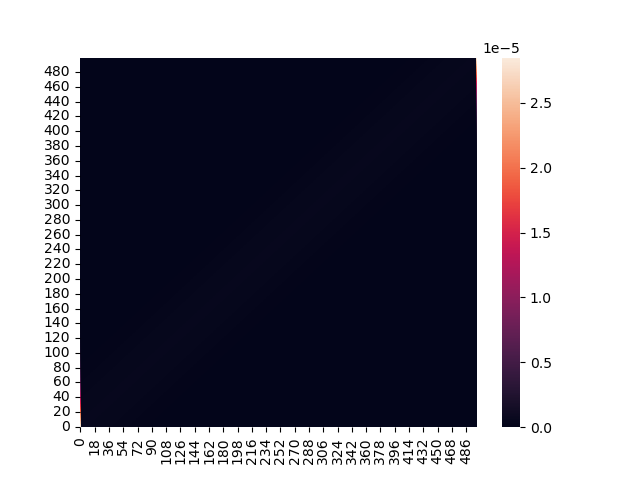

In [57]:
f, ax = plt.subplots()

sns.heatmap(kern2, ax=ax)

ax.invert_yaxis()

In [53]:
from scipy import signal

In [54]:
def get_kernel(vec, p, mutation_scale):

    N = len(vec)

    kernel = np.zeros((N, N))

    for parent in range(N):
        # some proportion stays at position i
        not_dispersing = signal.unit_impulse(N, parent)

        dispersing = dispersal(vec, parent, mutation_scale)

        kernel[parent, :] = p*dispersing + (1-p)*not_dispersing

    return kernel